### Get the data from the website and prepare it

File: PropertyData.txt  
Source: https://www.tad.org (Tarrant Appraisal District, TX)

In [216]:
import requests, zipfile, io, os
from pyspark.sql import SparkSession
from pyspark.sql.functions import monotonically_increasing_id, trim, col, udf
from pyspark.ml.feature import StringIndexer

spark = SparkSession.builder.master("local[*]").appName("PropertyData").getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled", True) # Property used to format output tables better
spark
zip_url = "https://www.tad.org/content/data-download/PropertyData(Delimited).ZIP"
source_file = "/tmp/spark/PropertyData.txt"

if os.path.isfile(source_file):
    print("Using existing property file")
else:
    download_url = "/tmp/spark/"
    r = requests.get(zip_url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall(download_url)

df = spark.read.csv(source_file, sep="|", header=True, inferSchema=True)
df = df.withColumn('id', monotonically_increasing_id())
df = df[['id'] + df.columns[:-1]]   # move id column to front
for name, dtype in df.dtypes:       # trim all string columns
    if dtype == "string":
        df = df.withColumn(name, trim(col(name)))

# convert certain string columns to number for use with regression
string_to_idx_columns = ['Swimming_Pool_Ind', 'Central_Heat_Ind', 'Central_Air_Ind']
for col_name in string_to_idx_columns:
    si = StringIndexer(inputCol=col_name, outputCol=f"{col_name}_idx")
    si = si.fit(df)
    df = si.transform(df)

# convert the Appraised_Value to integer
df = df.withColumn('Appraised_Value_Int', df['Appraised_Value'].cast('int'))

# drop specific columns we don't need going forward ...
drop_cols = ['Sequence_No', 'Record_Type', 'PIDN', 'Owner_Name', 'Owner_Address', 'Owner_CityState', 'Owner_Zip4',
             'Owner_CRRT', 'Situs_Address', 'TAD_Map', 'MAPSCO', 'Exemption_Code', 'State_Use_Code', 'LegalDescription',
             'Notice_Date', 'Deed_Date', 'Deed_Book', 'Appraisal_Date', 'Deed_Page', 'ARB_Indicator', 'From_Accts',
             'GIS_Link', 'Instrument_No', 'Overlap_Flag', 'Num_Bedrooms', 'Num_Bathrooms', 'Structure_Count', 'Ag_Code',
             'Appraisal_Year', 'Owner_Zip', 'Appraised_Value']
df = df.drop(*drop_cols)

# udpdate the view for SQL queries
df.createOrReplaceTempView("data")
# spark.sql('select * from data limit 10')

Using existing property file


In [217]:
# Define a UDF to calculate the percentage difference
from pyspark.sql.types import DoubleType
percent_diff_udf = udf(lambda new_value, old_value: round(((new_value - old_value) / old_value) * 100, 0) if old_value != 0 else None,
                       DoubleType())


In [218]:
# Define the feature columns
numerical_features = ['Spec1', 'Spec2', 'Spec3', 'Spec4', 'Spec5', 'Total_Value', 'Land_SqFt', 'Ag_Acres', 'Ag_Value',
                      # ,'Garage_Capacity', 'Living_Area', 'Central_Heat_Ind_idx', 'Land_Acres',
                      # ,'Land_Value', 'Improvement_Value', 'City', 'School', 'Swimming_Pool_Ind_idx', 'Num_Special_Dist',
                      ]

In [219]:
# Inspect dataframe for missing values
from pyspark.sql.functions import sum, col
missing_value_counts = df.select([sum(col(column).isNull().cast("int")).alias(column) for column in df.columns])
missing_value_counts.show()

# Drop rows containing missing values in the columns for features data
cleaned_df = df.dropna(subset=numerical_features)

+---+---+-----------+--------------+------+----+------+----------------+-----+-----+-----+-----+-----+----------+-----------------+-----------+---------------+----------+-----------+-----------------+----------+---------+--------+--------+----------------+---------------+---------------------+--------------------+-------------------+-------------------+
| id| RP|Account_Num|Property_Class|County|City|School|Num_Special_Dist|Spec1|Spec2|Spec3|Spec4|Spec5|Land_Value|Improvement_Value|Total_Value|Garage_Capacity|Year_Built|Living_Area|Swimming_Pool_Ind|Land_Acres|Land_SqFt|Ag_Acres|Ag_Value|Central_Heat_Ind|Central_Air_Ind|Swimming_Pool_Ind_idx|Central_Heat_Ind_idx|Central_Air_Ind_idx|Appraised_Value_Int|
+---+---+-----------+--------------+------+----+------+----------------+-----+-----+-----+-----+-----+----------+-----------------+-----------+---------------+----------+-----------+-----------------+----------+---------+--------+--------+----------------+---------------+----------------

### Start training models.

In [220]:
# Linear Regression
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator

train_linear, test_linear = cleaned_df.randomSplit([0.7, 0.3])
model_linear = LinearRegression(featuresCol='features', labelCol='Appraised_Value_Int')

assembler = VectorAssembler(inputCols=numerical_features, outputCol='features')
train_linear = assembler.transform(train_linear)
test_linear = assembler.transform(test_linear)

# Train the model
trained_model = model_linear.fit(train_linear)

# Evaluate the model
lr_predictions = trained_model.transform(test_linear)
evaluator = RegressionEvaluator(labelCol='Appraised_Value_Int', predictionCol='prediction', metricName='rmse')
rmse = evaluator.evaluate(lr_predictions)

# cast the predictions to integer and show the difference as integer and perentage
lr_predictions = lr_predictions.withColumn('prediction_int', lr_predictions['prediction'].cast('int'))
lr_predictions = lr_predictions.drop('prediction')
lr_predictions = lr_predictions.withColumn('diff', col('Appraised_Value_Int') - col('prediction_int'))
lr_predictions = lr_predictions.withColumn('diff_percent', percent_diff_udf(col('prediction_int'), col('Appraised_Value_Int')))

# create the view with summary data
lr_predictions.select('Account_Num', 'prediction_int', 'diff', 'diff_percent').createOrReplaceTempView("linear")

print("Root Mean Squared Error (RMSE):", round(rmse, 2))

23/06/14 17:00:14 WARN Instrumentation: [8660a3fa] regParam is zero, which might cause numerical instability and overfitting.
23/06/14 17:00:15 WARN Instrumentation: [8660a3fa] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.
23/06/14 17:00:15 ERROR LBFGS: Failure! Resetting history: breeze.optimize.FirstOrderException: Line search zoom failed


Root Mean Squared Error (RMSE): 66708.89


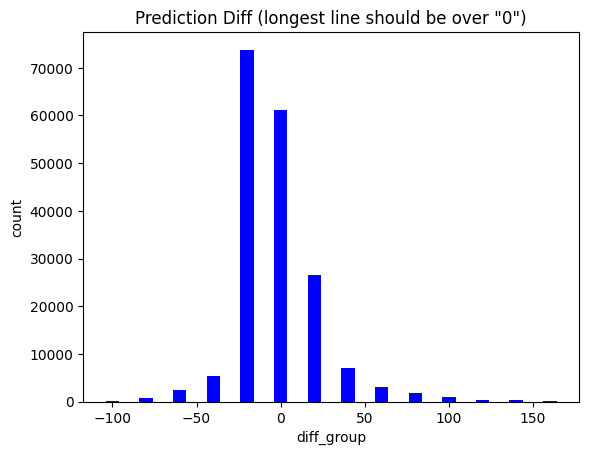

In [221]:
# let's take a look at some of the data
# we group the diff_percent values so there aren't too many records to graph
# also, here we are just looking at residential properties
query = """
with summary as (
  with src as (
    select FLOOR(CAST(diff_percent as INT) / 20) * 20 AS diff_group
    from linear 
    join data on data.Account_Num = linear.Account_Num
    where data.RP = 'R' 
      and Appraised_Value_Int > 20000
  )
  select count(diff_group) as count, diff_group from src group by 2 order by 2 desc
)
select count, diff_group from summary where count > 100
"""
res = spark.sql(query)
# res.show()

# graph it show how the predictions differ from the current appraisal values
import matplotlib.pyplot as plt
import pandas as pd
pandas_df = res.toPandas()
plt.bar(pandas_df['diff_group'], pandas_df['count'], color='blue', width=8)
plt.xlabel('diff_group')
plt.ylabel('count')
plt.title('Prediction Diff (longest line should be over "0")') # .. which would indicate more accurate prediction
plt.show()

In [222]:
query = """
select linear.*, data.*
from linear
join data on data.Account_Num = linear.Account_Num
where data.RP = 'R' 
    and Appraised_Value_Int > 10000
    and diff_percent between -5 and 5
order by diff_percent
"""
res = spark.sql(query)
res.show(500)

+-----------+--------------+-----+------------+------------+---+-----------+--------------+------+----+------+----------------+-----+-----+-----+-----+-----+----------+-----------------+-----------+---------------+----------+-----------+-----------------+----------+---------+--------+--------+----------------+---------------+---------------------+--------------------+-------------------+-------------------+
|Account_Num|prediction_int| diff|diff_percent|          id| RP|Account_Num|Property_Class|County|City|School|Num_Special_Dist|Spec1|Spec2|Spec3|Spec4|Spec5|Land_Value|Improvement_Value|Total_Value|Garage_Capacity|Year_Built|Living_Area|Swimming_Pool_Ind|Land_Acres|Land_SqFt|Ag_Acres|Ag_Value|Central_Heat_Ind|Central_Air_Ind|Swimming_Pool_Ind_idx|Central_Heat_Ind_idx|Central_Air_Ind_idx|Appraised_Value_Int|
+-----------+--------------+-----+------------+------------+---+-----------+--------------+------+----+------+----------------+-----+-----+-----+-----+-----+----------+----------